# MonReader

## Introduction

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

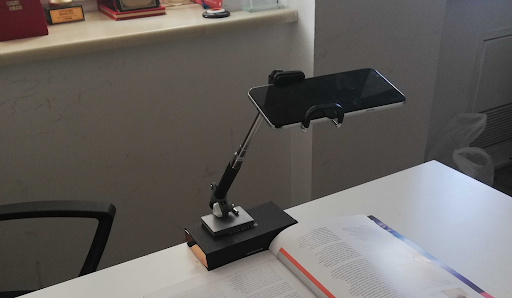

MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

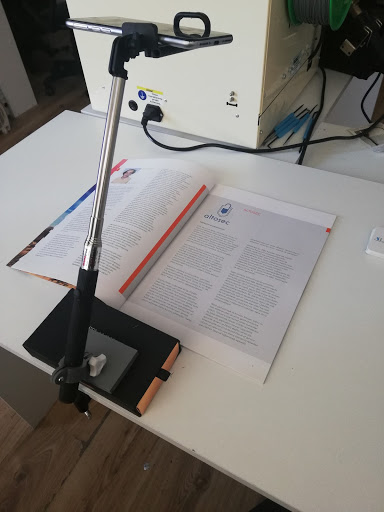

## Data Descrpition

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

The data can be downloaded from:
- https://drive.google.com/file/d/1KDQBTbo5deKGCdVV_xIujscn5ImxW4dm/view?usp=sharing

## Objective

- Predict if the page is being flipped using a single image.

### Importing Libraries

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


### Loading the Data

In [4]:
# setting folder paths with training and testing images
train_dir = "/Users/ahmedahmed/images/training"
test_dir = "/Users/ahmedahmed/images/testing"

### Create a Dataset

To read the images with their associated labels, a Keras pre-processing tool `tf.keras.utils.image_dataset_from_directory`is a function that generates a `tf.data.Dataset` from image files in a directory. It automatically reads all the image files, decodes them and label them depending on the folder the images were in. Also, shuffling and resizing of the images can be performed within the function.

The images that are provided all have dimensions of (1920x1080) and they need to be resized so the will be large and with too many features to train. The images will be resized to have dimensions of (180x180) and the data will be given to the model in batches of 32.

In [5]:
# parameters for the loader 
batch_size=32
img_height = 180
img_width = 180

# creating the training and testing datasets
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, seed=42, image_size=(img_height, img_width),
                                                      batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, seed=42, image_size=(img_height, img_width), 
                                                     batch_size=batch_size)

Found 2392 files belonging to 2 classes.
Metal device set to: Apple M1
Found 597 files belonging to 2 classes.


2022-09-05 14:01:41.353511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-05 14:01:41.353817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# checking the classes of both train and test
print(train_ds.class_names)
print(test_ds.class_names)

['flip', 'notflip']
['flip', 'notflip']


Now, we have two TensorFlow datasets that are divided into train_ds and test_ds and each dataset consists of:
* The train_ds has 2392 images that belongs to the two classes of "flip" and "notflip".
* The test_ds has 597 images that belongs to the two classes of "flip" and "notflip".

### Visualize the Data

A visualization of 9 samples from both train_ds and test_ds with their associated classes to give us an idea of how the pictures look like with their respective class. It helps to see how appropriate the data we are using are.

2022-09-05 14:21:37.054424: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


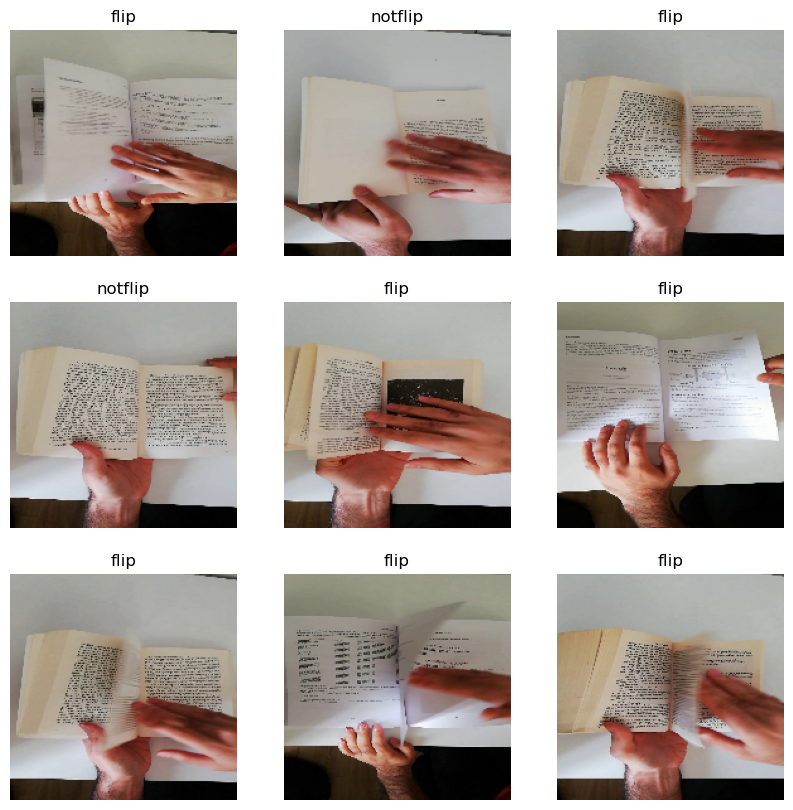

In [11]:
# displaying the first 9 pcitures in the training data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis('off')

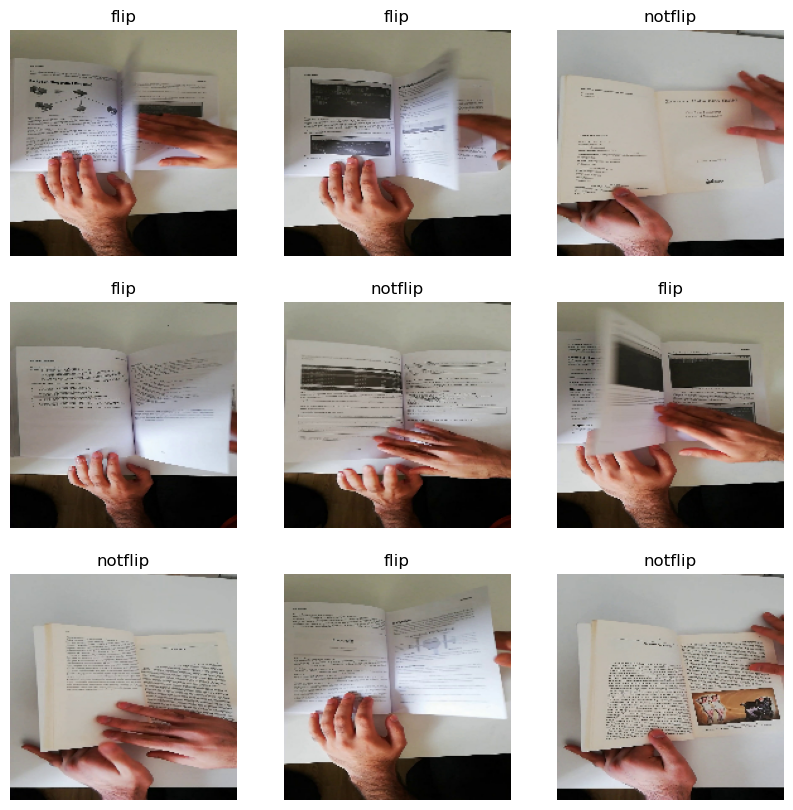

In [12]:
# displaying the first 9 pcitures in the test data
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(test_ds.class_names[labels[i]])
        plt.axis('off')

In [16]:
# shape of train_ds
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [17]:
# shape of test_ds
for image_batch, labels_batch in test_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The `labels_batch` is a tensor of the shape (32,), these are corresponding labels to the 32 images.

### Normalize the Data

Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1.

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. 

Here, I will standardize values to be in the [0, 1] range by using `tf.keras.layers.Rescaling`:

In [18]:
# creating a normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# applying it to the train_ds
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [19]:
# applying it to the test_ds
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_test_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9568647


### Configure the Dataset for Performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. 

These are two important methods you should use when loading data:
* `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* `Dataset.prefetch` overlaps data preprocessing and model execution while training.


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

normalized_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_test_ds = normalized_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating a Model

Since the objective of the project is straightforward and the data that we have is well-organized and clear. I decided to use a simple model instead of a complicated model and measure its performance.

The model I'm building is of a Keras Sequential model that consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function ('relu'). The output layer is a fully-connected layer (`tf.keras.layers.Dense`) with a single unit and a Sigmoid activation function.

In [28]:
# creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### Creating F1-Score Metric

A requirement in the project is to evaluate the performance of the model using the F1-score. The goal of the F1 score is to combine the precision and recall metrics into a single metric (the harmonic mean). At the same time, the F1 score has been designed to work well on imbalanced data.

The F1-Score is not part of the Keras metrics so I've written a function with the help of keras.backend that I found in an article from [medium](https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d).

In [31]:
# imporing keras.backend to create F1-Score
import keras.backend as K

# Function to calculate F1-Score 
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Compile the Model

In the compilation step, I've used the Adam optimizer that determines how the network will be updated based on the loss function. For the loss function I've used the Binary_Crossentropy for loss calculation of classificaton with only 2 classes. For the metrics I've used both F1-Score and the Accuracy to better evaluate the performance of the model. 

In [32]:
# compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', get_f1])

# model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 22, 22, 64)      

The model summary ensures that all the parameters are created as planned and there are a total of 3,988,769 trainable parameters.

### Train the Model

In this step, the model will be trained on the normalized_train_ds for 10 epochs and will be evaluated on the normalized_test_ds as the validation data and evaluated as per the metrics specified in the model which are the Accuracy and the F1-Score.

In [33]:
# training the model
history = model.fit(normalized_train_ds, validation_data=normalized_test_ds, epochs=10)

Epoch 1/10


2022-09-05 16:17:06.421422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - ETA: 0s - loss: 0.7080 - accuracy: 0.5865 - get_f1: 0.5722

2022-09-05 16:17:15.602711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 11s 109ms/step - loss: 0.7080 - accuracy: 0.5865 - get_f1: 0.5722 - val_loss: 0.5028 - val_accuracy: 0.7806 - val_get_f1: 0.8113
Epoch 2/10
75/75 [==============================] - 5s 67ms/step - loss: 0.3331 - accuracy: 0.8562 - get_f1: 0.8618 - val_loss: 0.2164 - val_accuracy: 0.9146 - val_get_f1: 0.9175
Epoch 3/10
75/75 [==============================] - 5s 67ms/step - loss: 0.1425 - accuracy: 0.9498 - get_f1: 0.9497 - val_loss: 0.2910 - val_accuracy: 0.8760 - val_get_f1: 0.8558
Epoch 4/10
75/75 [==============================] - 5s 67ms/step - loss: 0.0875 - accuracy: 0.9707 - get_f1: 0.9699 - val_loss: 0.1166 - val_accuracy: 0.9514 - val_get_f1: 0.9542
Epoch 5/10
75/75 [==============================] - 5s 68ms/step - loss: 0.0662 - accuracy: 0.9791 - get_f1: 0.9793 - val_loss: 0.0508 - val_accuracy: 0.9899 - val_get_f1: 0.9904
Epoch 6/10
75/75 [==============================] - 5s 68ms/step - loss: 0.0490 - accuracy: 0.9849 - get_f1: 0.984

In [67]:
print(f"The accuracy of the model on the training data: {np.max(history.history['accuracy']):.4f}")
print(f"The accuracy of the model on the testing data: {np.max(history.history['val_accuracy']):.4f}")
print(f"\nThe F1-Score of the model on the training data: {np.max(history.history['get_f1']):.4f}")
print(f"The F1-Score of the model on the testing data: {np.max(history.history['val_get_f1']):.4f}")

The accuracy of the model on the training data: 0.9992
The accuracy of the model on the testing data: 0.9950

The F1-Score of the model on the training data: 0.9992
The F1-Score of the model on the testing data: 0.9949


### Visualize Training Results

The training loss is a metric used to assess how a deep learning model fits the training data and validation loss is a metric used to assess the performance of a deep learning model on the validation set. The training and testing loss plots are considered to be optimization learning curves (to see how the model is being optimized) to help notice underfitting and overfitting. The training and testing plots are performance learning curves (to see how the model is performing) is capability of generalization and monitor underfitting and overfitting. 

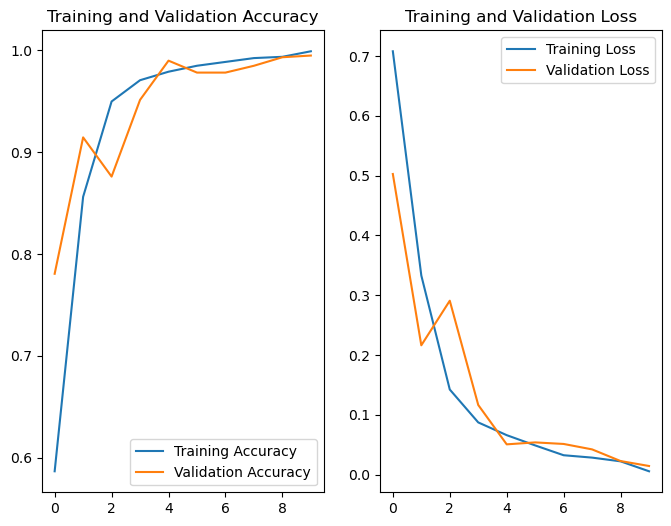

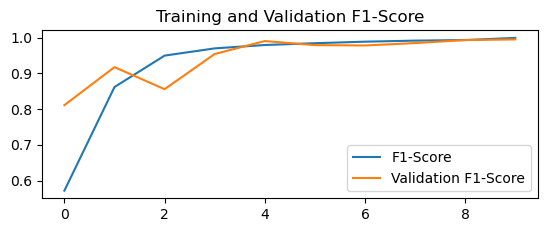

In [63]:
# Create plots of the loss and accuracy on the training and validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']

epochs_range = range(10)

plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(epochs_range, f1, label='F1-Score')
plt.plot(epochs_range, val_f1, label='Validation F1-Score')
plt.legend(loc='lower right')
plt.title("Training and Validation F1-Score")
plt.show()

## Conclusion

MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

The objective of the project was to work on the page flipping technology and predict from low-resolution images whether the page is being flipped or not. The data was provided by the company that consists of images and its associated labels of flip and nonflip. I've started by loading the data into two separate datasets of training and testing. Then, I've resized and rescaled the images for it to be in a lower-dimension which leads to simpler modeling and computation. At last, I've created a custom Convolutional Neural Network (CNN) model and applied it to the data and it yielded the following:
- The accuracy of the model on the training data: 0.9992
- The accuracy of the model on the testing data: 0.9950
- The F1-Score of the model on the training data: 0.9992
- The F1-Score of the model on the testing data: 0.9949